In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import osmnx as ox
import networkx as nx
from datetime import datetime
from dateutil import tz
import matplotlib.pyplot as plt

In [2]:
# Load dataset
data = pd.read_csv('../datasets/uber.csv',low_memory=False)
data.drop(columns=['key','Unnamed: 0'],inplace=True)
# data.dropna(inplace=True)

In [3]:
print(data.head().to_latex())

\begin{tabular}{lrlrrrrr}
\toprule
{} &  fare &                 datetime &   pick\_lon &   pick\_lat &   drop\_lon &   drop\_lat &  passenger \\
\midrule
0 &   7.5 &  2015-05-07 19:52:06 UTC & -73.999817 &  40.738354 & -73.999512 &  40.723217 &          1 \\
1 &   7.7 &  2009-07-17 20:04:56 UTC & -73.994355 &  40.728225 & -73.994710 &  40.750325 &          1 \\
2 &  12.9 &  2009-08-24 21:45:00 UTC & -74.005043 &  40.740770 & -73.962565 &  40.772647 &          1 \\
3 &   5.3 &  2009-06-26 08:22:21 UTC & -73.976124 &  40.790844 & -73.965316 &  40.803349 &          3 \\
4 &  16.0 &  2014-08-28 17:47:00 UTC & -73.925023 &  40.744085 & -73.973082 &  40.761247 &          5 \\
\bottomrule
\end{tabular}



/var/folders/0g/sh5twr412574pwntlhzb221w0000gn/T/ipykernel_58522/398733858.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.head().to_latex())


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   fare       200000 non-null  float64
 1   datetime   200000 non-null  object 
 2   pick_lon   200000 non-null  float64
 3   pick_lat   200000 non-null  float64
 4   drop_lon   199999 non-null  float64
 5   drop_lat   199999 non-null  float64
 6   passenger  200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


In [5]:
data[data.drop_lat.isna()]

,fare,datetime,pick_lon,pick_lat,drop_lon,drop_lat,passenger
87946,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


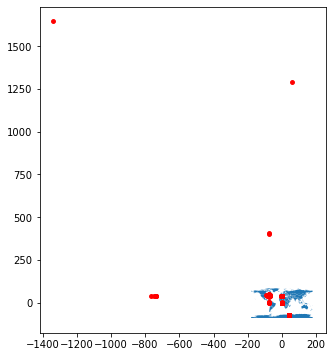

In [6]:
df = pd.DataFrame()
a = np.hstack((data[['pick_lon','pick_lat']],data[['drop_lon','drop_lat']]))
df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Let us first clear the obvious outliers: We need $-180 \leq lon \leq 180$ and $-90 \leq lat \leq 90$

In [7]:
# Clean the data in terms of outlier co-ordinates
data = data[~((data['pick_lon']>180) | (data['pick_lon']<-180) | (data['pick_lat']>90) | (data['pick_lat']<-90))]
data = data[~((data['drop_lon']>180) | (data['drop_lon']<-180) | (data['drop_lat']>90) | (data['drop_lat']<-90))]

array([[<AxesSubplot:title={'center':'pick_lat'}>,
        <AxesSubplot:title={'center':'drop_lat'}>],
       [<AxesSubplot:title={'center':'pick_lon'}>,
        <AxesSubplot:title={'center':'drop_lon'}>]], dtype=object)

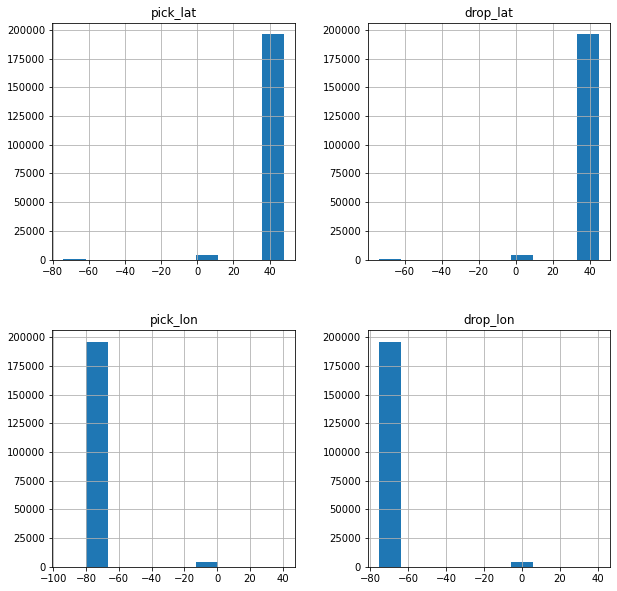

In [8]:
data.hist(["pick_lat","drop_lat","pick_lon","drop_lon"],figsize=(10,10))

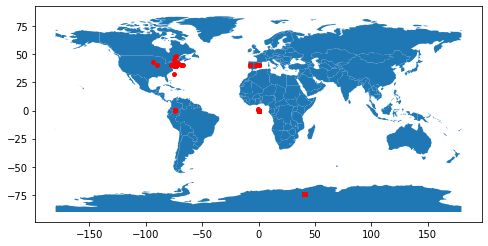

In [11]:
df = pd.DataFrame()
a = np.hstack((data[['pick_lon','pick_lat']],data[['drop_lon','drop_lat']]))
df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(8, 6)), marker='o', color='red', markersize=15);
plt.savefig('./figs/worldscatter.png',dpi=414,bbox_inches='tight')

Let us only keep the rides from around NYC

In [7]:
# Clean the data in terms of outlier co-ordinates
data = data[~((data['pick_lon']>-72) | (data['pick_lon']<-76) | (data['pick_lat']>42) | (data['pick_lat']<39))]
data = data[~((data['drop_lon']>-72) | (data['drop_lon']<-76) | (data['drop_lat']>42) | (data['drop_lat']<39))]

In [13]:
print('Number of data points removed = {} ({}%)'.format(200000-len(data),(200000-len(data))/2000))

Number of data points removed = 4153 (2.0765%)


In [15]:
df = pd.DataFrame()
a = np.vstack((data[['pick_lon','pick_lat']],data[['drop_lon','drop_lat']]))
df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

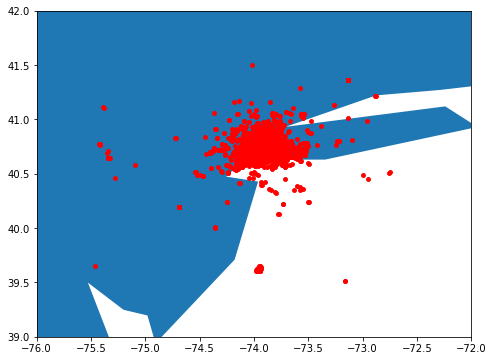

In [16]:
ax = gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
ax.set_xlim(-76, -72)
ax.set_ylim(39,42)
plt.savefig('./figs/nycscatter.pdf',dpi=414,bbox_inches='tight')

In [23]:
data

,fare,datetime,pick_lon,pick_lat,drop_lon,drop_lat,passenger
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [11]:
# Drop the key column
data = data.drop(columns=["key"])
# Convert the pickup time column to datatime format
data.pickup_datetime = pd.to_datetime(data.pickup_datetime)
data.pickup_datetime = data.pickup_datetime.dt.tz_convert('America/New_York')

Add additional columns related to the pick up time such as the year, quarter, month, day of the month, day of the week, hour of the day, isweekday

In [12]:
data [["year","quarter","month","day","dayofweek","hour"]] = [[time.year,time.quarter, time.month,time.day,time.dayofweek,time.hour] for time in data.pickup_datetime]
data["isweekend"] = (data.dayofweek > 4)*1

In [13]:
data

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,quarter,month,day,dayofweek,hour,isweekend
24238194,7.5,2015-05-07 15:52:06-04:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,2,5,7,3,15,0
27835199,7.7,2009-07-17 16:04:56-04:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,3,7,17,4,16,0
44984355,12.9,2009-08-24 17:45:00-04:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,3,8,24,0,17,0
25894730,5.3,2009-06-26 04:22:21-04:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,2,6,26,4,4,0
17610152,16.0,2014-08-28 13:47:00-04:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,8,28,3,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42598914,3.0,2012-10-28 06:49:00-04:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,4,10,28,6,6,1
16382965,7.5,2014-03-13 21:09:00-04:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,1,3,13,3,21,0
27804658,30.9,2009-06-28 20:42:00-04:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,2,6,28,6,20,1
20259894,14.5,2015-05-20 10:56:25-04:00,-73.997124,40.725452,-73.983215,40.695415,1,2015,2,5,20,2,10,0


In [14]:
# graph_area = ["New York, USA"]
# G = ox.graph_from_place(graph_area, network_type='drive')
# G = ox.add_edge_speeds(G)
# G = ox.add_edge_travel_times(G)
# ox.save_graphml(G, "NewYork.graphml")

G = ox.load_graphml("Manhattan.graphml")

# origin_coordinates = (40.70195053163349, -74.01123198479581)
# destination_coordinates = (40.87148739347057, -73.91517498611597)
# origin_node = ox.distance.nearest_nodes(G, origin_coordinates[1], origin_coordinates[0])
# destination_node = ox.distance.nearest_nodes(G, destination_coordinates[1], destination_coordinates[0])

# distance_in_meters = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
# print(distance_in_meters)

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

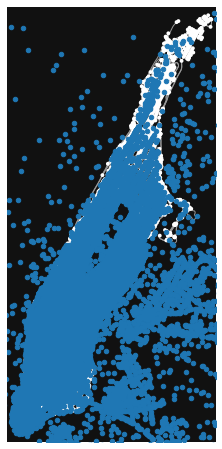

In [15]:
fig, ax = ox.plot_graph(G, show=False, close=False)
data.plot(x='pickup_longitude',y='pick_lat',kind='scatter',ax=ax)

In [15]:
X = data[['pickup_longitude','pick_lat']] # np.hstack((data[['pickup_longitude','pick_lat']],data[['drop_lon','drop_lat']]))

In [4]:
X = data.pickup_longitude
sortX = np.sort(X)
sortX
Q1 = np.percentile(X, 5, interpolation = 'midpoint') 
Q2 = np.percentile(X, 50, interpolation = 'midpoint') 
Q3 = np.percentile(X, 95, interpolation = 'midpoint') 
  
print('Q1 25 percentile of the given data is, ', Q1)
print('Q1 50 percentile of the given data is, ', Q2)
print('Q1 75 percentile of the given data is, ', Q3)
  
IQR = Q3 - Q1 
print('Interquartile range is', IQR)

Q1 25 percentile of the given data is,  -74.006838
Q1 50 percentile of the given data is,  -73.98182299999999
Q1 75 percentile of the given data is,  -73.871196
Interquartile range is 0.13564200000000426


/var/folders/0g/sh5twr412574pwntlhzb221w0000gn/T/ipykernel_55556/468686387.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(X, 5, interpolation = 'midpoint')
/var/folders/0g/sh5twr412574pwntlhzb221w0000gn/T/ipykernel_55556/468686387.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q2 = np.percentile(X, 50, interpolation = 'midpoint')
/var/folders/0g/sh5twr412574pwntlhzb221w0000gn/T/ipykernel_55556/468686387.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest'

In [5]:
low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
print('low_limit is', low_lim)
print('up_limit is', up_lim)

low_limit is -74.21030100000002
up_limit is -73.667733


In [32]:
outlier =[]
for i, x in enumerate(X):
    if ((x> up_lim) or (x<low_lim)):
         outlier.append(i)
print(' outlier in the dataset is', len(outlier))

 outlier in the dataset is 4103


In [41]:
data[['pickup_longitude','pick_lat','drop_lon','drop_lat']].iloc[outlier]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
44195482,0.0,0.000000,0.000000,0.000000
6379048,0.0,0.000000,0.000000,0.000000
21993993,0.0,0.000000,0.000000,0.000000
1454546,0.0,0.000000,0.000000,0.000000
17358122,0.0,0.000000,0.000000,0.000000
...,...,...,...,...
46007628,0.0,0.000000,0.000000,0.000000
35013970,0.0,0.000000,0.000000,0.000000
44115598,0.0,0.000000,0.000000,0.000000
44787414,-736.4,40.774307,-73.982215,40.769672


In [6]:
G = ox.graph_from_bbox( 42, 39, -72, -76, network_type='drive', simplify=True, retain_all=False)

In [ ]:
ox.save_graphml(G, "BBox.graphml")